In [59]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne_nirs.statistics import statsmodels_to_results

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl
from mne.stats import fdr_correction


# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [60]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 50

# Time from trigger point being evaluated
tmin = -1
tmax = 50

# How you would like to rename the numeric triggers from Aurora
# trigger_id = None
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}
# trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}
trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

# What files would you like to ignore while looping through subjects
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
ignore = [".DS_Store", ".git", ".gitignore", 'sub-1']

# Mock data folder to test pulling meta data from folder structure.
# path = "../../LabResearch/IndependentStudy/Data/BIDS-NIRS-Tapping"
# path = "../../LabResearch/IndependentStudy/Data/FA"
# path = '../../FV_Prelim_Data'
path = '../../../Desktop/n-back-bids/'

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False

# Specifies what columns to use for the GLM constrast. If None, contrast is skipped
# Only two columns can be specified
# columns_for_glm_contrast = ['Neutral', 'Inflam', 'Control']
# columns_for_glm_contrast = ['Neutral', 'Concern']
columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']

# Specifies what columns to use for group level analysis.
# columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']
# columns_for_group_analysis = ['Neutral', 'Concern']
columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']

In [61]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [62]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        
        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [63]:
importlib.reload(glm_analysis)
group_data, all_epochs, all_evokeds, glm_results = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax, trigger_id=trigger_id)

print(glm_results)


Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../../Desktop/n-back-bids/all-groups/sub-01/nirs/2023-03-24_003.snirf
Reading 0 ... 5000  =      0.000 ...   491.500 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../../Desktop/n-back-bids/all-groups/sub-02/nirs/2023-03-24_004.snirf
Reading 0 ... 4558  =      0.000 ...   448.051 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../../Desktop/n-back-bids/all-groups/sub-03/nirs/2023-03-24_005.snirf
Reading 0 ... 5672  =      0.000 ...   557.558 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../../Desktop/n-back-bids/all-groups/sub-04/nirs/2023-03-24_006.snirf
Reading 0 ... 5389  =      0.000 ...   529.739 secs...
Event [340   0   2] 50
Event [340   0   2] 50
Event [340   0   2] 50
Event [302   0   2] 50
Event [302   0   2] 50
Event [302   0   2] 50
Event [373   0   2] 50
Event [373   0   2] 50
Event [373   0   2] 50
Event [370   0   2] 50
Event [370   0

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig_df['Coef.'] = sig_df['Coef.']*1e7
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig_df['Coef.'] = sig_df['Coef.']*1e7


In [64]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, trigger_id)
# individual_data

# Visualizations

17


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:75: RuntimeWarning: MNE data structure does not match regression results
  plot_glm_group_topo(raw_haemo.copy().pick(picks=chroma), model_data,


TypeError: '<' not supported between instances of 'str' and 'float'

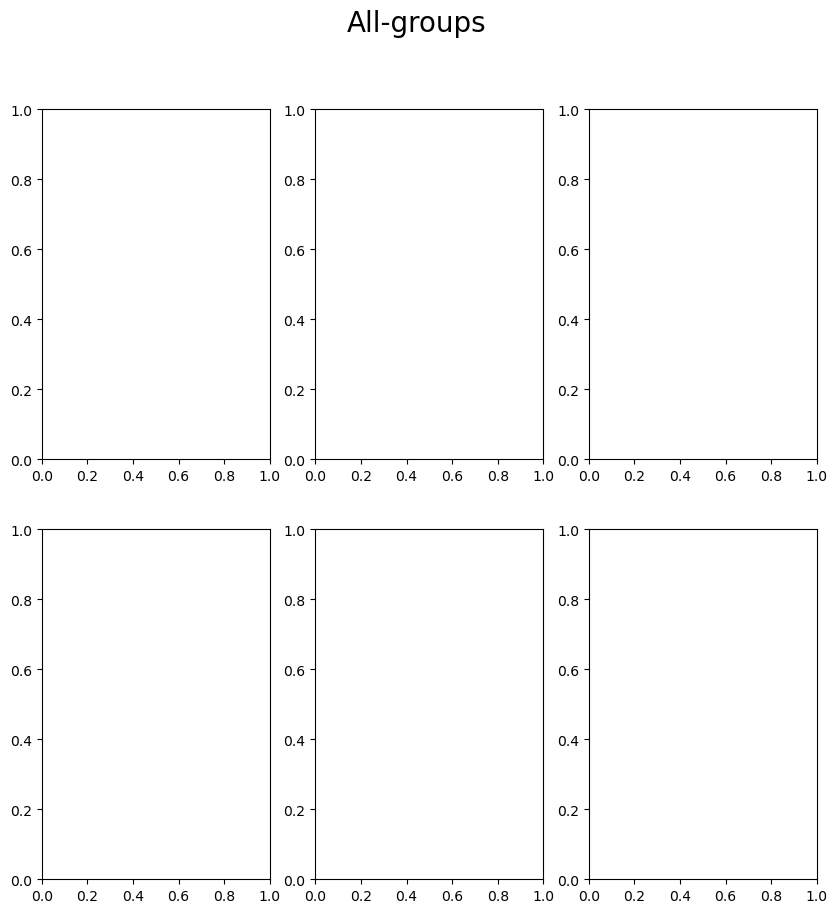

In [69]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

In [ ]:
# # Group Visualization with FDR Correction
# importlib.reload(visualizations)
# importlib.reload(analysis_tools)
# ignored_vals = ['drift', 'Start', 'constant']

# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
#     channels_df_fdr = analysis_tools.false_discovery_rate_correction(channels_df, ignored_vals)

#     raw_haemo = all_data[0]['raw_haemo']
#     # visualizations.group_topological_visualisation(channels_df_fdr, columns_for_glm_contrast, raw_haemo, group)
#     # dataframe = visualizations.group_topological_visualisation_with_fdr(channels_df_fdr, raw_haemo)
# channels_df_fdr

In [ ]:
# # Group Cortical Projections
# importlib.reload(visualizations)
# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

#     raw_haemo = all_data[0]['raw_haemo']
#     visualizations.group_cortical_surface_projection(channels_df, columns_for_glm_contrast, raw_haemo, path)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


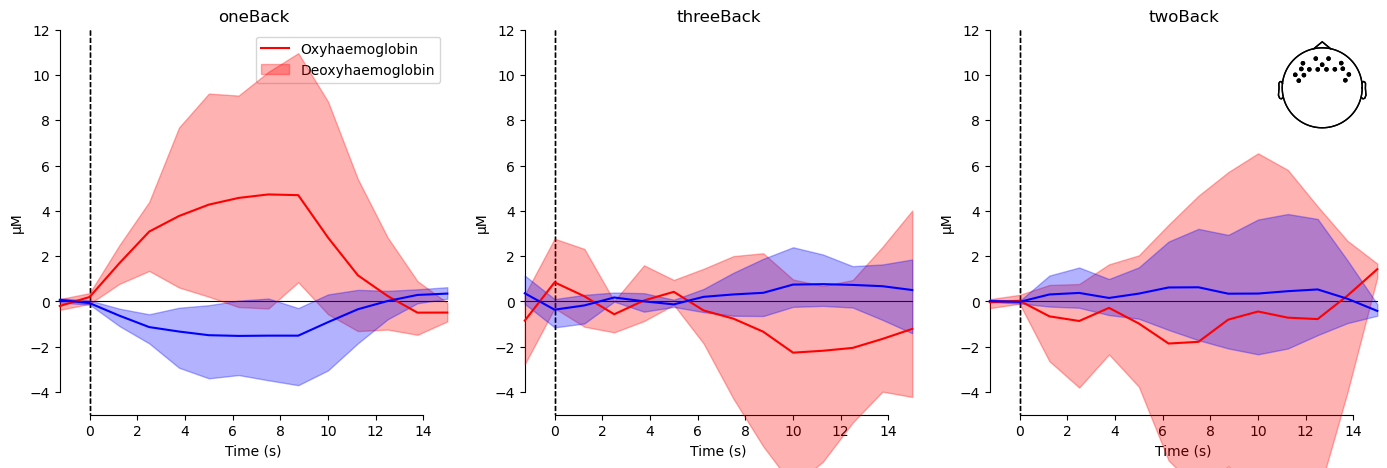

In [ ]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, interval_length, variable_epoch_time)

In [ ]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [ ]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])
    complete_results['Coef.'] = complete_results['Coef.'] * 1e6
complete_results.to_csv('oculus_significant_channels.csv')